# Environment Setup

In [1]:
# General
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchinfo import summary
from torchmetrics import MetricCollection, Accuracy, JaccardIndex

# CubiCasa
from floortrans.loaders import FloorplanSVG
from floortrans.loaders.augmentations import (RandomCropToSizeTorch,
                                              ResizePaddedTorch,
                                              Compose,
                                              DictToTensor,
                                              ColorJitterTorch,
                                              RandomRotations)

# Model
from models.deeplabv3plus import DeepLabV3Plus

# Release GPU memory
torch.cuda.empty_cache()
print('GPU memory has been released.')

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using device: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Using device: CPU')


print('Setup complete.')

GPU memory has been released.
Using device: NVIDIA GeForce RTX 3060 Laptop GPU
Setup complete.


# Data Preprocessing and Augmentations

In [2]:
IMAGE_SIZE = (256, 256)

train_aug = Compose([
    # transforms.RandomChoice([
    #     RandomCropToSizeTorch(data_format='dict', size=IMAGE_SIZE),
    #     ResizePaddedTorch((0, 0), data_format='dict', size=IMAGE_SIZE)
    # ]),
    ResizePaddedTorch((0, 0), data_format='dict', size=IMAGE_SIZE),
    RandomRotations(format='cubi'),
    DictToTensor(),
    ColorJitterTorch()
])

val_aug = Compose([
    ResizePaddedTorch((0, 0), data_format='dict', size=IMAGE_SIZE),
    DictToTensor()
])

# Dataset

In [3]:
DATA_PATH = 'data/cubicasa5k/'
TRAIN_PATH = 'train.txt'
VAL_PATH = 'val.txt'
FORMAT = 'lmdb'

full_train_set = FloorplanSVG(
    DATA_PATH, 
    TRAIN_PATH, 
    format=FORMAT, 
    augmentations=train_aug
)

# Reduce training set for faster training (temporary)
train_set = Subset(full_train_set, list(range(1600)))

val_set = FloorplanSVG(
    DATA_PATH, 
    VAL_PATH, 
    format=FORMAT, 
    augmentations=val_aug
)

print('Train set size:', len(train_set))
print('Validation set size:', len(val_set))

Train set size: 1600
Validation set size: 400


In [4]:
sample = train_set[10]

print('Image shape:', sample['image'].shape)
print('Label shape (overall):', sample['label'].shape)

# Room and icon segmentation maps
print('\nLabel shape (rooms): ', sample['label'][21].shape)
print('Label shape (icons):', sample['label'][22].shape)
print()

# Heatmaps
for i in range(21):
    print(f'Label shape (heatmap {i+1}):', sample['label'][i].shape)

Image shape: torch.Size([3, 256, 256])
Label shape (overall): torch.Size([23, 256, 256])

Label shape (rooms):  torch.Size([256, 256])
Label shape (icons): torch.Size([256, 256])

Label shape (heatmap 1): torch.Size([256, 256])
Label shape (heatmap 2): torch.Size([256, 256])
Label shape (heatmap 3): torch.Size([256, 256])
Label shape (heatmap 4): torch.Size([256, 256])
Label shape (heatmap 5): torch.Size([256, 256])
Label shape (heatmap 6): torch.Size([256, 256])
Label shape (heatmap 7): torch.Size([256, 256])
Label shape (heatmap 8): torch.Size([256, 256])
Label shape (heatmap 9): torch.Size([256, 256])
Label shape (heatmap 10): torch.Size([256, 256])
Label shape (heatmap 11): torch.Size([256, 256])
Label shape (heatmap 12): torch.Size([256, 256])
Label shape (heatmap 13): torch.Size([256, 256])
Label shape (heatmap 14): torch.Size([256, 256])
Label shape (heatmap 15): torch.Size([256, 256])
Label shape (heatmap 16): torch.Size([256, 256])
Label shape (heatmap 17): torch.Size([256, 25

In [5]:
print('Image: ', sample['image'])

Image:  tensor([[[1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         ...,
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513]],

        [[1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         ...,
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513]],

        [[1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.1513, 1.1513],
         [1.1513, 1.1513, 1.1513,  ..., 1.1513, 1.

In [6]:
print('Label: ', sample['label'])

Label:  tensor([[[-4.4603e-17, -4.4783e-17, -4.5104e-17,  ..., -3.1364e-17,
          -3.2125e-17, -3.1703e-17],
         [ 1.0926e-17,  8.3350e-18,  8.7733e-18,  ...,  4.7212e-17,
           4.6568e-17,  4.5346e-17],
         [ 2.1442e-17,  2.0995e-17,  2.1421e-17,  ...,  2.4113e-18,
           2.6412e-18,  2.8155e-18],
         ...,
         [-9.3134e-17, -9.2628e-17, -9.2397e-17,  ...,  1.8345e-17,
           1.7906e-17,  2.0234e-17],
         [-3.1437e-17, -3.1989e-17, -3.0833e-17,  ...,  2.9546e-17,
           2.9530e-17,  3.1213e-17],
         [ 5.1813e-18,  6.7555e-18,  8.1467e-18,  ...,  3.3093e-17,
           3.2660e-17,  3.5343e-17]],

        [[ 8.0323e-18,  6.1511e-18,  4.0239e-18,  ..., -4.1396e-17,
          -4.1157e-17, -4.0416e-17],
         [-4.8468e-18, -6.7096e-18, -8.2814e-18,  ..., -1.4310e-19,
          -3.4468e-19,  1.2791e-18],
         [-3.8282e-17, -3.8208e-17, -3.8162e-17,  ..., -2.4219e-18,
          -2.3842e-18, -3.1899e-18],
         ...,
         [ 1.0469

# Save label to numpy/tensor

In [7]:
# label_tensor = sample['label']
# label_np = label_tensor.numpy()

# # Save the label as a numpy array
# np.save('model_outputs/floorplan_pred.npy', label_np)

# # Save as tensor
# torch.save(label_tensor, 'model_outputs/floorplan_pred.pt')


# Visualize Images and Labels

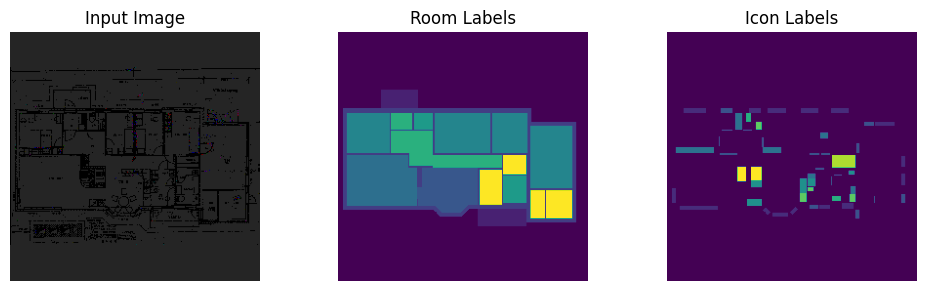

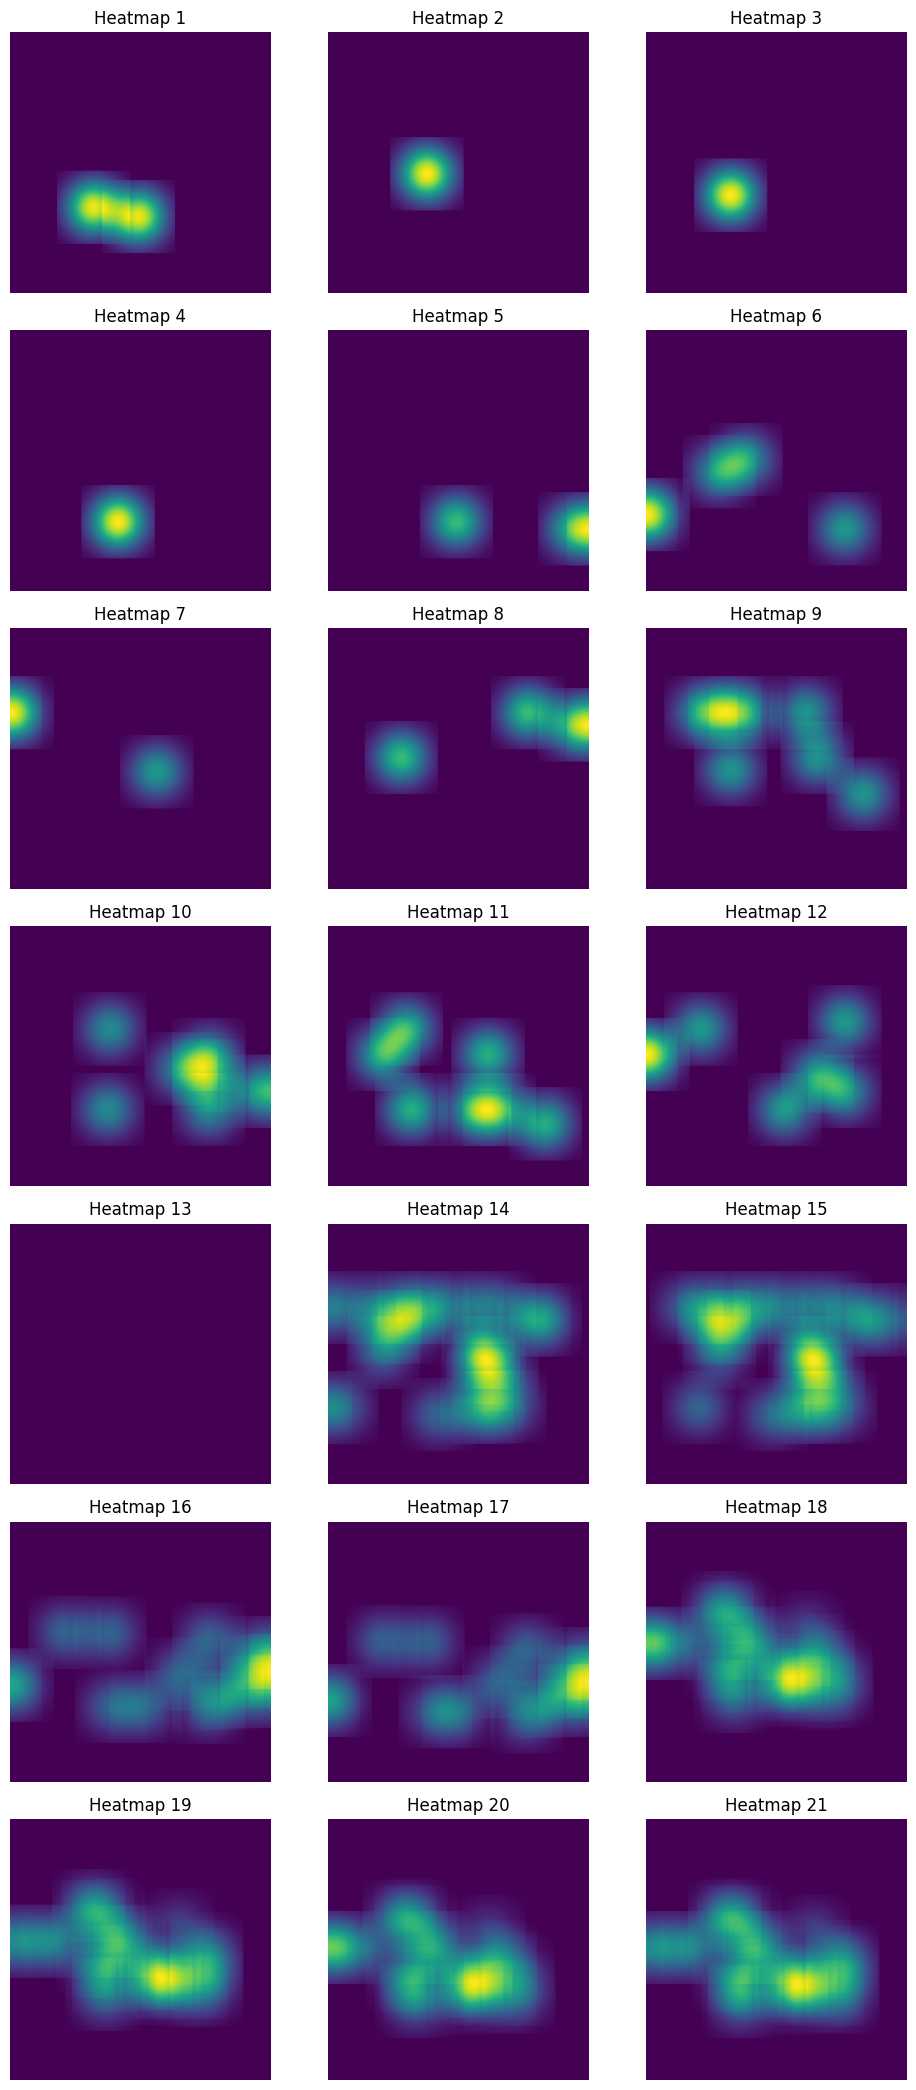

In [8]:
# Convert back to [0, 255] range
tensor_image = sample['image'] * 255.0

np_image = tensor_image.numpy().astype(np.uint8)  # Convert to unsigned 8-bit integer

# Transpose to [H, W, 3] from [3, H, W]
np_image = np.transpose(np_image, (1, 2, 0))

# Create figure with 1 row and 3 columns for the first set of visualizations
fig, axes = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 3 columns

# Input image
axes[0].imshow(np_image)
axes[0].axis('off')  # Remove the axes
axes[0].set_title('Input Image')

# Room segmentation map
axes[1].imshow(sample['label'][21])
axes[1].axis('off')  # Remove the axes
axes[1].set_title('Room Labels')

# Icon segmentation map
axes[2].imshow(sample['label'][22])
axes[2].axis('off')
axes[2].set_title('Icon Labels')

plt.tight_layout()
plt.show()

# Now display the heatmaps, 3 heatmaps per row
num_heatmaps = 21
cols = 3
rows = (num_heatmaps + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for i in range(num_heatmaps):
    row = i // cols
    col = i % cols
    axes[row, col].imshow(sample['label'][i])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Heatmap {i+1}')

# If there are empty spaces in the last row (if heatmaps < total subplots), hide them
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])  # Remove unused subplots

plt.tight_layout()
plt.show()


# DataLoader

In [9]:
NUM_WORKERS = 0
BATCH_SIZE = 16

train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=True, 
    pin_memory=True
)

val_loader = DataLoader(
    val_set, 
    batch_size=1, 
    num_workers=NUM_WORKERS, 
    pin_memory=True
)

print(f'Length of train dataloader: {len(train_loader)} batches of size {BATCH_SIZE}')
print(f'Length of val dataloader: {len(val_loader)} batches of size {BATCH_SIZE}')

batch_sample = next(iter(train_loader))
print('\nBatch image shape: ', batch_sample['image'].shape)
print('Batch label shape: ', batch_sample['label'].shape)

Length of train dataloader: 100 batches of size 16
Length of val dataloader: 400 batches of size 16

Batch image shape:  torch.Size([16, 3, 256, 256])
Batch label shape:  torch.Size([16, 23, 256, 256])


# Model Setup

For reference, here are the 23 classes:  

- **Rooms (12):** "Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"  

- **Icons (11):** "No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"

In [10]:
model = DeepLabV3Plus(backbone='mobilenetv2', attention=False)
model.to(device)

summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                                       Output Shape              Param #
DeepLabV3Plus                                                [16, 12, 256, 256]        --
├─Backbone: 1-1                                              [16, 24, 64, 64]          --
│    └─MobileNetV2: 2-1                                      --                        1,281,000
│    │    └─Sequential: 3-1                                  --                        2,223,872
├─ASPP: 1-2                                                  [16, 256, 8, 8]           --
│    └─Conv2d: 2-2                                           [16, 256, 8, 8]           327,680
│    └─AtrousConv: 2-3                                       [16, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-2                      [16, 256, 8, 8]           339,712
│    └─AtrousConv: 2-4                                       [16, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-3                      [16, 256, 

In [11]:
# # Verifying output shapes
# sample_input = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)

# room_output, icon_output, heatmap_output = model(sample_input)
# print('Room Output Shape:', room_output.shape)  # Expected: [16, 12, 256, 256]
# print('Icon Output Shape:', icon_output.shape)  # Expected: [16, 11, 256, 256]
# print('Heatmap Output Shape:', heatmap_output.shape)  # Expected: [16, 21, 256, 256]

# Loss Function: Multi-Task Uncertainty Loss 

In [12]:
class MultiTaskUncertaintyLoss(nn.Module):
    def __init__(self, num_tasks=2):
        super().__init__()

        # Learnable parameter for each task
        self.log_sigma = nn.Parameter(torch.zeros(num_tasks))


    def forward(self, losses):
        """
        Forward pass to compute the total multi-task loss.
        Args:
            losses (list of tensors): List of individual task losses.
        Returns:
            total_loss (tensor): The final weighted multi-task loss.
        """

        # Tensor to avoid issues with autograd
        total_loss = torch.tensor(0.0, requires_grad=True).to(losses[0].device)

        for i, loss in enumerate(losses):
            precision_weight = torch.exp(-self.log_sigma[i])
            task_loss = precision_weight * loss + self.log_sigma[i]
            total_loss = total_loss + task_loss
        
        return total_loss

# Updated Training and Validation Loop

In [13]:
# Individual loss functions for each task
room_loss_fn = nn.CrossEntropyLoss()
icon_loss_fn = nn.CrossEntropyLoss()
heatmap_loss_fn = nn.MSELoss()

# Multi-task uncertainty loss
multitask_loss = MultiTaskUncertaintyLoss(num_tasks=3).to(device)

# Based on CubiCasa5k training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

# Reduce learning rate if validation loss doesnt improve for 20 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# Evaluation metrics
room_metrics = MetricCollection({
    'mpa': Accuracy(task='multiclass', num_classes=12, average='macro'),
    'miou': JaccardIndex(task='multiclass', num_classes=12, average='macro'),
    'fwiou': JaccardIndex(task='multiclass', num_classes=12, average='weighted'),
}).to(device)

icon_metrics = MetricCollection({
    'mpa': Accuracy(task='multiclass', num_classes=11, average='macro'),
    'miou': JaccardIndex(task='multiclass', num_classes=11, average='macro'),
    'fwiou': JaccardIndex(task='multiclass', num_classes=11, average='weighted'),
}).to(device)


# Training loop
def train(model, dataloader, optimizer, device):
    model.train()

    total_loss = 0.0

    # To show progress bar
    for batch in tqdm(dataloader, desc='Training'):
        images = batch['image'].float().to(device)
        room_labels = batch['label'][:, 21].long().to(device)
        icon_labels = batch['label'][:, 22].long().to(device)
        heatmap_labels = batch['label'][:, 0:21].to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        room_output, icon_output, heatmap_output = model(images)

        # Compute individual losses per task
        room_loss = room_loss_fn(room_output, room_labels)
        icon_loss = icon_loss_fn(icon_output, icon_labels)
        heatmap_loss = heatmap_loss_fn(heatmap_output, heatmap_labels)

        # Compute combined loss
        combined_loss = multitask_loss([room_loss, icon_loss, heatmap_loss])

        # Backward pass and optimization
        combined_loss.backward()
        optimizer.step()

        # Accumulate the scalar value of the loss
        total_loss += combined_loss.item()

        # Get model predictions
        room_preds = torch.argmax(room_output, dim=1)
        icon_preds = torch.argmax(icon_output, dim=1)

        # Update metrics
        room_metrics.update(room_preds, room_labels)
        icon_metrics.update(icon_preds, icon_labels)

    # Compute epoch loss and metrics
    epoch_loss = total_loss / len(dataloader)
    epoch_room_metrics = room_metrics.compute()
    epoch_icon_metrics = icon_metrics.compute()

    # Reset metrics
    room_metrics.reset()
    icon_metrics.reset()

    return epoch_loss, epoch_room_metrics, epoch_icon_metrics


# Validation loop
def validate(model, dataloader, device):
    model.eval()

    total_loss = 0.0

    # Don't compute gradients
    with torch.no_grad():

        # Wrap dataloader with tqdm to show progress bar
        for batch in tqdm(dataloader, desc='Validating'):
            images = batch['image'].float().to(device)

            room_labels = batch['label'][:, 21].long().to(device)
            icon_labels = batch['label'][:, 22].long().to(device)
            heatmap_labels = batch['label'][:, 0:21].to(device)

            # Forward pass
            room_output, icon_output, heatmap_output = model(images)

            # Compute individual losses
            room_loss = room_loss_fn(room_output, room_labels)
            icon_loss = icon_loss_fn(icon_output, icon_labels)
            heatmap_loss = heatmap_loss_fn(heatmap_output, heatmap_labels)

            # Compute combined loss
            combined_loss = multitask_loss([room_loss, icon_loss, heatmap_loss])

            # Accumulate the scalar value of the loss
            total_loss += combined_loss.item()

            # Get model predictions
            room_preds = torch.argmax(room_output, dim=1)
            icon_preds = torch.argmax(icon_output, dim=1)

            # Update metrics
            room_metrics.update(room_preds, room_labels)
            icon_metrics.update(icon_preds, icon_labels)
    
    # Compute epoch loss and metrics
    epoch_loss = total_loss / len(dataloader)
    epoch_room_metrics = room_metrics.compute()
    epoch_icon_metrics = icon_metrics.compute()

    # Reset metrics
    room_metrics.reset()
    icon_metrics.reset()
    
    return epoch_loss, epoch_room_metrics, epoch_icon_metrics


# Train and validate model
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"EPOCH {epoch+1}/{num_epochs}")

    train_loss, train_room_metrics, train_icon_metrics = train(model, train_loader, optimizer, device)
    val_loss, val_room_metrics, val_icon_metrics = validate(model, val_loader, device)

    print('\nTRAIN RESULTS')
    print(f'Loss: {train_loss:.4f}')
    print(f'Rooms: {train_room_metrics}')
    print(f'Icons: {train_icon_metrics}')

    print('\nVALIDATION RESULTS')
    print(f'Loss: {val_loss:.4f}')
    print(f'Rooms: {val_room_metrics}')
    print(f'Icons: {val_icon_metrics}')

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'saved_models/deeplabv3plus_{model.backbone_name}.pt')
        print(f'\nBest model saved with validation loss: {best_val_loss:.4f}')
    else:
        print(f'\nValidation loss did not improve.Best loss is still: {best_val_loss:.4f}')

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')


EPOCH 1/50


Validating: 100%|██████████| 400/400 [00:52<00:00,  7.58it/s]



TRAIN RESULTS
Loss: 1.5742
Rooms: {'fwiou': tensor(0.4918, device='cuda:0'), 'miou': tensor(0.1255, device='cuda:0'), 'mpa': tensor(0.1860, device='cuda:0')}
Icons: {'fwiou': tensor(0.8893, device='cuda:0'), 'miou': tensor(0.0857, device='cuda:0'), 'mpa': tensor(0.0917, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.2050
Rooms: {'fwiou': tensor(0.5311, device='cuda:0'), 'miou': tensor(0.1550, device='cuda:0'), 'mpa': tensor(0.2230, device='cuda:0')}
Icons: {'fwiou': tensor(0.9087, device='cuda:0'), 'miou': tensor(0.0867, device='cuda:0'), 'mpa': tensor(0.0909, device='cuda:0')}

Best model saved with validation loss: 1.2050

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 2/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.82it/s]



TRAIN RESULTS
Loss: 1.1699
Rooms: {'fwiou': tensor(0.5560, device='cuda:0'), 'miou': tensor(0.1767, device='cuda:0'), 'mpa': tensor(0.2525, device='cuda:0')}
Icons: {'fwiou': tensor(0.9096, device='cuda:0'), 'miou': tensor(0.0867, device='cuda:0'), 'mpa': tensor(0.0909, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.1356
Rooms: {'fwiou': tensor(0.5540, device='cuda:0'), 'miou': tensor(0.1775, device='cuda:0'), 'mpa': tensor(0.2502, device='cuda:0')}
Icons: {'fwiou': tensor(0.9087, device='cuda:0'), 'miou': tensor(0.0867, device='cuda:0'), 'mpa': tensor(0.0909, device='cuda:0')}

Best model saved with validation loss: 1.1356

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 3/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.85it/s]



TRAIN RESULTS
Loss: 1.1035
Rooms: {'fwiou': tensor(0.5774, device='cuda:0'), 'miou': tensor(0.2054, device='cuda:0'), 'mpa': tensor(0.2884, device='cuda:0')}
Icons: {'fwiou': tensor(0.9097, device='cuda:0'), 'miou': tensor(0.0870, device='cuda:0'), 'mpa': tensor(0.0912, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0959
Rooms: {'fwiou': tensor(0.5658, device='cuda:0'), 'miou': tensor(0.1919, device='cuda:0'), 'mpa': tensor(0.2686, device='cuda:0')}
Icons: {'fwiou': tensor(0.9087, device='cuda:0'), 'miou': tensor(0.0869, device='cuda:0'), 'mpa': tensor(0.0912, device='cuda:0')}

Best model saved with validation loss: 1.0959

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 4/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.87it/s]



TRAIN RESULTS
Loss: 1.0551
Rooms: {'fwiou': tensor(0.5929, device='cuda:0'), 'miou': tensor(0.2236, device='cuda:0'), 'mpa': tensor(0.3104, device='cuda:0')}
Icons: {'fwiou': tensor(0.9099, device='cuda:0'), 'miou': tensor(0.0884, device='cuda:0'), 'mpa': tensor(0.0926, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0577
Rooms: {'fwiou': tensor(0.5964, device='cuda:0'), 'miou': tensor(0.2156, device='cuda:0'), 'mpa': tensor(0.3027, device='cuda:0')}
Icons: {'fwiou': tensor(0.9091, device='cuda:0'), 'miou': tensor(0.0891, device='cuda:0'), 'mpa': tensor(0.0933, device='cuda:0')}

Best model saved with validation loss: 1.0577

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 5/50


Validating: 100%|██████████| 400/400 [00:57<00:00,  6.93it/s]



TRAIN RESULTS
Loss: 1.0212
Rooms: {'fwiou': tensor(0.6038, device='cuda:0'), 'miou': tensor(0.2414, device='cuda:0'), 'mpa': tensor(0.3322, device='cuda:0')}
Icons: {'fwiou': tensor(0.9103, device='cuda:0'), 'miou': tensor(0.0903, device='cuda:0'), 'mpa': tensor(0.0945, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0451
Rooms: {'fwiou': tensor(0.5894, device='cuda:0'), 'miou': tensor(0.2286, device='cuda:0'), 'mpa': tensor(0.3187, device='cuda:0')}
Icons: {'fwiou': tensor(0.9098, device='cuda:0'), 'miou': tensor(0.0927, device='cuda:0'), 'mpa': tensor(0.0970, device='cuda:0')}

Best model saved with validation loss: 1.0451

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 6/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.78it/s]



TRAIN RESULTS
Loss: 0.9927
Rooms: {'fwiou': tensor(0.6160, device='cuda:0'), 'miou': tensor(0.2602, device='cuda:0'), 'mpa': tensor(0.3543, device='cuda:0')}
Icons: {'fwiou': tensor(0.9110, device='cuda:0'), 'miou': tensor(0.0943, device='cuda:0'), 'mpa': tensor(0.0986, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0450
Rooms: {'fwiou': tensor(0.5775, device='cuda:0'), 'miou': tensor(0.2228, device='cuda:0'), 'mpa': tensor(0.3049, device='cuda:0')}
Icons: {'fwiou': tensor(0.9102, device='cuda:0'), 'miou': tensor(0.0948, device='cuda:0'), 'mpa': tensor(0.0992, device='cuda:0')}

Best model saved with validation loss: 1.0450

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 7/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]



TRAIN RESULTS
Loss: 0.9711
Rooms: {'fwiou': tensor(0.6226, device='cuda:0'), 'miou': tensor(0.2711, device='cuda:0'), 'mpa': tensor(0.3689, device='cuda:0')}
Icons: {'fwiou': tensor(0.9114, device='cuda:0'), 'miou': tensor(0.0971, device='cuda:0'), 'mpa': tensor(0.1015, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0243
Rooms: {'fwiou': tensor(0.5956, device='cuda:0'), 'miou': tensor(0.2360, device='cuda:0'), 'mpa': tensor(0.3271, device='cuda:0')}
Icons: {'fwiou': tensor(0.9114, device='cuda:0'), 'miou': tensor(0.1032, device='cuda:0'), 'mpa': tensor(0.1083, device='cuda:0')}

Best model saved with validation loss: 1.0243

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 8/50


Validating: 100%|██████████| 400/400 [01:00<00:00,  6.67it/s]



TRAIN RESULTS
Loss: 0.9539
Rooms: {'fwiou': tensor(0.6263, device='cuda:0'), 'miou': tensor(0.2805, device='cuda:0'), 'mpa': tensor(0.3806, device='cuda:0')}
Icons: {'fwiou': tensor(0.9120, device='cuda:0'), 'miou': tensor(0.1007, device='cuda:0'), 'mpa': tensor(0.1053, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0033
Rooms: {'fwiou': tensor(0.6057, device='cuda:0'), 'miou': tensor(0.2500, device='cuda:0'), 'mpa': tensor(0.3406, device='cuda:0')}
Icons: {'fwiou': tensor(0.9115, device='cuda:0'), 'miou': tensor(0.1043, device='cuda:0'), 'mpa': tensor(0.1096, device='cuda:0')}

Best model saved with validation loss: 1.0033

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 9/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.88it/s]



TRAIN RESULTS
Loss: 0.9305
Rooms: {'fwiou': tensor(0.6354, device='cuda:0'), 'miou': tensor(0.2923, device='cuda:0'), 'mpa': tensor(0.3941, device='cuda:0')}
Icons: {'fwiou': tensor(0.9126, device='cuda:0'), 'miou': tensor(0.1047, device='cuda:0'), 'mpa': tensor(0.1096, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9952
Rooms: {'fwiou': tensor(0.6135, device='cuda:0'), 'miou': tensor(0.2485, device='cuda:0'), 'mpa': tensor(0.3341, device='cuda:0')}
Icons: {'fwiou': tensor(0.9119, device='cuda:0'), 'miou': tensor(0.1059, device='cuda:0'), 'mpa': tensor(0.1110, device='cuda:0')}

Best model saved with validation loss: 0.9952

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 10/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.89it/s]



TRAIN RESULTS
Loss: 0.9155
Rooms: {'fwiou': tensor(0.6410, device='cuda:0'), 'miou': tensor(0.3028, device='cuda:0'), 'mpa': tensor(0.4051, device='cuda:0')}
Icons: {'fwiou': tensor(0.9130, device='cuda:0'), 'miou': tensor(0.1069, device='cuda:0'), 'mpa': tensor(0.1119, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0158
Rooms: {'fwiou': tensor(0.6109, device='cuda:0'), 'miou': tensor(0.2585, device='cuda:0'), 'mpa': tensor(0.3501, device='cuda:0')}
Icons: {'fwiou': tensor(0.9120, device='cuda:0'), 'miou': tensor(0.1092, device='cuda:0'), 'mpa': tensor(0.1152, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9952

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 11/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.85it/s]



TRAIN RESULTS
Loss: 0.8999
Rooms: {'fwiou': tensor(0.6461, device='cuda:0'), 'miou': tensor(0.3115, device='cuda:0'), 'mpa': tensor(0.4156, device='cuda:0')}
Icons: {'fwiou': tensor(0.9133, device='cuda:0'), 'miou': tensor(0.1094, device='cuda:0'), 'mpa': tensor(0.1148, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9977
Rooms: {'fwiou': tensor(0.6107, device='cuda:0'), 'miou': tensor(0.2613, device='cuda:0'), 'mpa': tensor(0.3469, device='cuda:0')}
Icons: {'fwiou': tensor(0.9118, device='cuda:0'), 'miou': tensor(0.1078, device='cuda:0'), 'mpa': tensor(0.1134, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9952

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 12/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]



TRAIN RESULTS
Loss: 0.8827
Rooms: {'fwiou': tensor(0.6520, device='cuda:0'), 'miou': tensor(0.3201, device='cuda:0'), 'mpa': tensor(0.4252, device='cuda:0')}
Icons: {'fwiou': tensor(0.9139, device='cuda:0'), 'miou': tensor(0.1127, device='cuda:0'), 'mpa': tensor(0.1182, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9971
Rooms: {'fwiou': tensor(0.6093, device='cuda:0'), 'miou': tensor(0.2580, device='cuda:0'), 'mpa': tensor(0.3497, device='cuda:0')}
Icons: {'fwiou': tensor(0.9126, device='cuda:0'), 'miou': tensor(0.1115, device='cuda:0'), 'mpa': tensor(0.1175, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9952

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 13/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s]



TRAIN RESULTS
Loss: 0.8672
Rooms: {'fwiou': tensor(0.6574, device='cuda:0'), 'miou': tensor(0.3318, device='cuda:0'), 'mpa': tensor(0.4393, device='cuda:0')}
Icons: {'fwiou': tensor(0.9142, device='cuda:0'), 'miou': tensor(0.1150, device='cuda:0'), 'mpa': tensor(0.1208, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9818
Rooms: {'fwiou': tensor(0.6046, device='cuda:0'), 'miou': tensor(0.2695, device='cuda:0'), 'mpa': tensor(0.3641, device='cuda:0')}
Icons: {'fwiou': tensor(0.9134, device='cuda:0'), 'miou': tensor(0.1142, device='cuda:0'), 'mpa': tensor(0.1206, device='cuda:0')}

Best model saved with validation loss: 0.9818

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 14/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]



TRAIN RESULTS
Loss: 0.8540
Rooms: {'fwiou': tensor(0.6615, device='cuda:0'), 'miou': tensor(0.3353, device='cuda:0'), 'mpa': tensor(0.4429, device='cuda:0')}
Icons: {'fwiou': tensor(0.9145, device='cuda:0'), 'miou': tensor(0.1176, device='cuda:0'), 'mpa': tensor(0.1238, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0093
Rooms: {'fwiou': tensor(0.5991, device='cuda:0'), 'miou': tensor(0.2731, device='cuda:0'), 'mpa': tensor(0.3753, device='cuda:0')}
Icons: {'fwiou': tensor(0.9127, device='cuda:0'), 'miou': tensor(0.1131, device='cuda:0'), 'mpa': tensor(0.1188, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9818

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 15/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.78it/s]



TRAIN RESULTS
Loss: 0.8513
Rooms: {'fwiou': tensor(0.6619, device='cuda:0'), 'miou': tensor(0.3407, device='cuda:0'), 'mpa': tensor(0.4487, device='cuda:0')}
Icons: {'fwiou': tensor(0.9149, device='cuda:0'), 'miou': tensor(0.1200, device='cuda:0'), 'mpa': tensor(0.1263, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9900
Rooms: {'fwiou': tensor(0.6205, device='cuda:0'), 'miou': tensor(0.2767, device='cuda:0'), 'mpa': tensor(0.3796, device='cuda:0')}
Icons: {'fwiou': tensor(0.9129, device='cuda:0'), 'miou': tensor(0.1117, device='cuda:0'), 'mpa': tensor(0.1172, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9818

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 16/50


Validating: 100%|██████████| 400/400 [01:00<00:00,  6.66it/s]



TRAIN RESULTS
Loss: 0.8337
Rooms: {'fwiou': tensor(0.6691, device='cuda:0'), 'miou': tensor(0.3503, device='cuda:0'), 'mpa': tensor(0.4607, device='cuda:0')}
Icons: {'fwiou': tensor(0.9151, device='cuda:0'), 'miou': tensor(0.1207, device='cuda:0'), 'mpa': tensor(0.1273, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9747
Rooms: {'fwiou': tensor(0.6164, device='cuda:0'), 'miou': tensor(0.2712, device='cuda:0'), 'mpa': tensor(0.3687, device='cuda:0')}
Icons: {'fwiou': tensor(0.9133, device='cuda:0'), 'miou': tensor(0.1175, device='cuda:0'), 'mpa': tensor(0.1237, device='cuda:0')}

Best model saved with validation loss: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 17/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]



TRAIN RESULTS
Loss: 0.8215
Rooms: {'fwiou': tensor(0.6742, device='cuda:0'), 'miou': tensor(0.3595, device='cuda:0'), 'mpa': tensor(0.4704, device='cuda:0')}
Icons: {'fwiou': tensor(0.9154, device='cuda:0'), 'miou': tensor(0.1230, device='cuda:0'), 'mpa': tensor(0.1297, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9988
Rooms: {'fwiou': tensor(0.6128, device='cuda:0'), 'miou': tensor(0.2784, device='cuda:0'), 'mpa': tensor(0.3704, device='cuda:0')}
Icons: {'fwiou': tensor(0.9131, device='cuda:0'), 'miou': tensor(0.1165, device='cuda:0'), 'mpa': tensor(0.1228, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 18/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.82it/s]



TRAIN RESULTS
Loss: 0.8125
Rooms: {'fwiou': tensor(0.6767, device='cuda:0'), 'miou': tensor(0.3602, device='cuda:0'), 'mpa': tensor(0.4708, device='cuda:0')}
Icons: {'fwiou': tensor(0.9158, device='cuda:0'), 'miou': tensor(0.1256, device='cuda:0'), 'mpa': tensor(0.1326, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0025
Rooms: {'fwiou': tensor(0.6164, device='cuda:0'), 'miou': tensor(0.2692, device='cuda:0'), 'mpa': tensor(0.3715, device='cuda:0')}
Icons: {'fwiou': tensor(0.9129, device='cuda:0'), 'miou': tensor(0.1155, device='cuda:0'), 'mpa': tensor(0.1216, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 19/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]



TRAIN RESULTS
Loss: 0.7995
Rooms: {'fwiou': tensor(0.6813, device='cuda:0'), 'miou': tensor(0.3694, device='cuda:0'), 'mpa': tensor(0.4809, device='cuda:0')}
Icons: {'fwiou': tensor(0.9159, device='cuda:0'), 'miou': tensor(0.1271, device='cuda:0'), 'mpa': tensor(0.1345, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0323
Rooms: {'fwiou': tensor(0.6056, device='cuda:0'), 'miou': tensor(0.2607, device='cuda:0'), 'mpa': tensor(0.3500, device='cuda:0')}
Icons: {'fwiou': tensor(0.9130, device='cuda:0'), 'miou': tensor(0.1152, device='cuda:0'), 'mpa': tensor(0.1221, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 20/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s]



TRAIN RESULTS
Loss: 0.7870
Rooms: {'fwiou': tensor(0.6859, device='cuda:0'), 'miou': tensor(0.3766, device='cuda:0'), 'mpa': tensor(0.4895, device='cuda:0')}
Icons: {'fwiou': tensor(0.9162, device='cuda:0'), 'miou': tensor(0.1285, device='cuda:0'), 'mpa': tensor(0.1360, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0066
Rooms: {'fwiou': tensor(0.6135, device='cuda:0'), 'miou': tensor(0.2747, device='cuda:0'), 'mpa': tensor(0.3727, device='cuda:0')}
Icons: {'fwiou': tensor(0.9148, device='cuda:0'), 'miou': tensor(0.1272, device='cuda:0'), 'mpa': tensor(0.1362, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 21/50


Validating: 100%|██████████| 400/400 [00:57<00:00,  6.90it/s]



TRAIN RESULTS
Loss: 0.7775
Rooms: {'fwiou': tensor(0.6899, device='cuda:0'), 'miou': tensor(0.3876, device='cuda:0'), 'mpa': tensor(0.5021, device='cuda:0')}
Icons: {'fwiou': tensor(0.9166, device='cuda:0'), 'miou': tensor(0.1316, device='cuda:0'), 'mpa': tensor(0.1396, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9874
Rooms: {'fwiou': tensor(0.6175, device='cuda:0'), 'miou': tensor(0.2744, device='cuda:0'), 'mpa': tensor(0.3643, device='cuda:0')}
Icons: {'fwiou': tensor(0.9149, device='cuda:0'), 'miou': tensor(0.1271, device='cuda:0'), 'mpa': tensor(0.1356, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 22/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.78it/s]



TRAIN RESULTS
Loss: 0.7661
Rooms: {'fwiou': tensor(0.6928, device='cuda:0'), 'miou': tensor(0.3922, device='cuda:0'), 'mpa': tensor(0.5060, device='cuda:0')}
Icons: {'fwiou': tensor(0.9167, device='cuda:0'), 'miou': tensor(0.1323, device='cuda:0'), 'mpa': tensor(0.1405, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9850
Rooms: {'fwiou': tensor(0.6243, device='cuda:0'), 'miou': tensor(0.2838, device='cuda:0'), 'mpa': tensor(0.3821, device='cuda:0')}
Icons: {'fwiou': tensor(0.9141, device='cuda:0'), 'miou': tensor(0.1202, device='cuda:0'), 'mpa': tensor(0.1263, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 23/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s]



TRAIN RESULTS
Loss: 0.7634
Rooms: {'fwiou': tensor(0.6933, device='cuda:0'), 'miou': tensor(0.3924, device='cuda:0'), 'mpa': tensor(0.5071, device='cuda:0')}
Icons: {'fwiou': tensor(0.9168, device='cuda:0'), 'miou': tensor(0.1327, device='cuda:0'), 'mpa': tensor(0.1407, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9795
Rooms: {'fwiou': tensor(0.6215, device='cuda:0'), 'miou': tensor(0.2837, device='cuda:0'), 'mpa': tensor(0.3884, device='cuda:0')}
Icons: {'fwiou': tensor(0.9145, device='cuda:0'), 'miou': tensor(0.1239, device='cuda:0'), 'mpa': tensor(0.1314, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 24/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.78it/s]



TRAIN RESULTS
Loss: 0.7579
Rooms: {'fwiou': tensor(0.6963, device='cuda:0'), 'miou': tensor(0.3999, device='cuda:0'), 'mpa': tensor(0.5154, device='cuda:0')}
Icons: {'fwiou': tensor(0.9169, device='cuda:0'), 'miou': tensor(0.1332, device='cuda:0'), 'mpa': tensor(0.1413, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0100
Rooms: {'fwiou': tensor(0.6172, device='cuda:0'), 'miou': tensor(0.2759, device='cuda:0'), 'mpa': tensor(0.3633, device='cuda:0')}
Icons: {'fwiou': tensor(0.9134, device='cuda:0'), 'miou': tensor(0.1174, device='cuda:0'), 'mpa': tensor(0.1233, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 25/50


Validating: 100%|██████████| 400/400 [00:57<00:00,  6.90it/s]



TRAIN RESULTS
Loss: 0.7412
Rooms: {'fwiou': tensor(0.7027, device='cuda:0'), 'miou': tensor(0.4083, device='cuda:0'), 'mpa': tensor(0.5239, device='cuda:0')}
Icons: {'fwiou': tensor(0.9172, device='cuda:0'), 'miou': tensor(0.1363, device='cuda:0'), 'mpa': tensor(0.1450, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9969
Rooms: {'fwiou': tensor(0.6245, device='cuda:0'), 'miou': tensor(0.2772, device='cuda:0'), 'mpa': tensor(0.3729, device='cuda:0')}
Icons: {'fwiou': tensor(0.9135, device='cuda:0'), 'miou': tensor(0.1191, device='cuda:0'), 'mpa': tensor(0.1253, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 26/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]



TRAIN RESULTS
Loss: 0.7294
Rooms: {'fwiou': tensor(0.7072, device='cuda:0'), 'miou': tensor(0.4154, device='cuda:0'), 'mpa': tensor(0.5321, device='cuda:0')}
Icons: {'fwiou': tensor(0.9176, device='cuda:0'), 'miou': tensor(0.1383, device='cuda:0'), 'mpa': tensor(0.1472, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0220
Rooms: {'fwiou': tensor(0.6075, device='cuda:0'), 'miou': tensor(0.2757, device='cuda:0'), 'mpa': tensor(0.3707, device='cuda:0')}
Icons: {'fwiou': tensor(0.9140, device='cuda:0'), 'miou': tensor(0.1203, device='cuda:0'), 'mpa': tensor(0.1266, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 27/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]



TRAIN RESULTS
Loss: 0.7176
Rooms: {'fwiou': tensor(0.7116, device='cuda:0'), 'miou': tensor(0.4225, device='cuda:0'), 'mpa': tensor(0.5381, device='cuda:0')}
Icons: {'fwiou': tensor(0.9181, device='cuda:0'), 'miou': tensor(0.1414, device='cuda:0'), 'mpa': tensor(0.1506, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0217
Rooms: {'fwiou': tensor(0.6242, device='cuda:0'), 'miou': tensor(0.2871, device='cuda:0'), 'mpa': tensor(0.3858, device='cuda:0')}
Icons: {'fwiou': tensor(0.9157, device='cuda:0'), 'miou': tensor(0.1322, device='cuda:0'), 'mpa': tensor(0.1410, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 28/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.81it/s]



TRAIN RESULTS
Loss: 0.7151
Rooms: {'fwiou': tensor(0.7124, device='cuda:0'), 'miou': tensor(0.4205, device='cuda:0'), 'mpa': tensor(0.5371, device='cuda:0')}
Icons: {'fwiou': tensor(0.9179, device='cuda:0'), 'miou': tensor(0.1418, device='cuda:0'), 'mpa': tensor(0.1512, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0183
Rooms: {'fwiou': tensor(0.6134, device='cuda:0'), 'miou': tensor(0.2665, device='cuda:0'), 'mpa': tensor(0.3618, device='cuda:0')}
Icons: {'fwiou': tensor(0.9150, device='cuda:0'), 'miou': tensor(0.1306, device='cuda:0'), 'mpa': tensor(0.1394, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 29/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.70it/s]



TRAIN RESULTS
Loss: 0.6990
Rooms: {'fwiou': tensor(0.7172, device='cuda:0'), 'miou': tensor(0.4298, device='cuda:0'), 'mpa': tensor(0.5458, device='cuda:0')}
Icons: {'fwiou': tensor(0.9183, device='cuda:0'), 'miou': tensor(0.1441, device='cuda:0'), 'mpa': tensor(0.1537, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0107
Rooms: {'fwiou': tensor(0.6154, device='cuda:0'), 'miou': tensor(0.2765, device='cuda:0'), 'mpa': tensor(0.3661, device='cuda:0')}
Icons: {'fwiou': tensor(0.9151, device='cuda:0'), 'miou': tensor(0.1278, device='cuda:0'), 'mpa': tensor(0.1353, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 30/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.79it/s]



TRAIN RESULTS
Loss: 0.6938
Rooms: {'fwiou': tensor(0.7196, device='cuda:0'), 'miou': tensor(0.4376, device='cuda:0'), 'mpa': tensor(0.5539, device='cuda:0')}
Icons: {'fwiou': tensor(0.9184, device='cuda:0'), 'miou': tensor(0.1445, device='cuda:0'), 'mpa': tensor(0.1542, device='cuda:0')}

VALIDATION RESULTS
Loss: 0.9927
Rooms: {'fwiou': tensor(0.6220, device='cuda:0'), 'miou': tensor(0.2969, device='cuda:0'), 'mpa': tensor(0.3992, device='cuda:0')}
Icons: {'fwiou': tensor(0.9158, device='cuda:0'), 'miou': tensor(0.1397, device='cuda:0'), 'mpa': tensor(0.1513, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 31/50


Validating: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]



TRAIN RESULTS
Loss: 0.6900
Rooms: {'fwiou': tensor(0.7212, device='cuda:0'), 'miou': tensor(0.4359, device='cuda:0'), 'mpa': tensor(0.5538, device='cuda:0')}
Icons: {'fwiou': tensor(0.9184, device='cuda:0'), 'miou': tensor(0.1449, device='cuda:0'), 'mpa': tensor(0.1551, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0048
Rooms: {'fwiou': tensor(0.6318, device='cuda:0'), 'miou': tensor(0.2928, device='cuda:0'), 'mpa': tensor(0.3906, device='cuda:0')}
Icons: {'fwiou': tensor(0.9150, device='cuda:0'), 'miou': tensor(0.1320, device='cuda:0'), 'mpa': tensor(0.1412, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 32/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.76it/s]



TRAIN RESULTS
Loss: 0.6743
Rooms: {'fwiou': tensor(0.7284, device='cuda:0'), 'miou': tensor(0.4523, device='cuda:0'), 'mpa': tensor(0.5677, device='cuda:0')}
Icons: {'fwiou': tensor(0.9189, device='cuda:0'), 'miou': tensor(0.1482, device='cuda:0'), 'mpa': tensor(0.1585, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0471
Rooms: {'fwiou': tensor(0.6172, device='cuda:0'), 'miou': tensor(0.2750, device='cuda:0'), 'mpa': tensor(0.3756, device='cuda:0')}
Icons: {'fwiou': tensor(0.9150, device='cuda:0'), 'miou': tensor(0.1300, device='cuda:0'), 'mpa': tensor(0.1385, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 33/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]



TRAIN RESULTS
Loss: 0.6657
Rooms: {'fwiou': tensor(0.7306, device='cuda:0'), 'miou': tensor(0.4550, device='cuda:0'), 'mpa': tensor(0.5714, device='cuda:0')}
Icons: {'fwiou': tensor(0.9192, device='cuda:0'), 'miou': tensor(0.1503, device='cuda:0'), 'mpa': tensor(0.1610, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0221
Rooms: {'fwiou': tensor(0.6214, device='cuda:0'), 'miou': tensor(0.2915, device='cuda:0'), 'mpa': tensor(0.4011, device='cuda:0')}
Icons: {'fwiou': tensor(0.9149, device='cuda:0'), 'miou': tensor(0.1295, device='cuda:0'), 'mpa': tensor(0.1374, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 34/50


Validating: 100%|██████████| 400/400 [00:59<00:00,  6.70it/s]



TRAIN RESULTS
Loss: 0.6673
Rooms: {'fwiou': tensor(0.7294, device='cuda:0'), 'miou': tensor(0.4544, device='cuda:0'), 'mpa': tensor(0.5720, device='cuda:0')}
Icons: {'fwiou': tensor(0.9192, device='cuda:0'), 'miou': tensor(0.1508, device='cuda:0'), 'mpa': tensor(0.1617, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0163
Rooms: {'fwiou': tensor(0.6189, device='cuda:0'), 'miou': tensor(0.2808, device='cuda:0'), 'mpa': tensor(0.3732, device='cuda:0')}
Icons: {'fwiou': tensor(0.9149, device='cuda:0'), 'miou': tensor(0.1245, device='cuda:0'), 'mpa': tensor(0.1310, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 35/50


Validating: 100%|██████████| 400/400 [00:58<00:00,  6.80it/s]



TRAIN RESULTS
Loss: 0.6608
Rooms: {'fwiou': tensor(0.7320, device='cuda:0'), 'miou': tensor(0.4570, device='cuda:0'), 'mpa': tensor(0.5737, device='cuda:0')}
Icons: {'fwiou': tensor(0.9194, device='cuda:0'), 'miou': tensor(0.1512, device='cuda:0'), 'mpa': tensor(0.1619, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0447
Rooms: {'fwiou': tensor(0.6268, device='cuda:0'), 'miou': tensor(0.2901, device='cuda:0'), 'mpa': tensor(0.3883, device='cuda:0')}
Icons: {'fwiou': tensor(0.9165, device='cuda:0'), 'miou': tensor(0.1404, device='cuda:0'), 'mpa': tensor(0.1513, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 36/50


Validating: 100%|██████████| 400/400 [01:03<00:00,  6.30it/s]



TRAIN RESULTS
Loss: 0.6465
Rooms: {'fwiou': tensor(0.7376, device='cuda:0'), 'miou': tensor(0.4682, device='cuda:0'), 'mpa': tensor(0.5852, device='cuda:0')}
Icons: {'fwiou': tensor(0.9197, device='cuda:0'), 'miou': tensor(0.1542, device='cuda:0'), 'mpa': tensor(0.1655, device='cuda:0')}

VALIDATION RESULTS
Loss: 1.0600
Rooms: {'fwiou': tensor(0.6191, device='cuda:0'), 'miou': tensor(0.2823, device='cuda:0'), 'mpa': tensor(0.3861, device='cuda:0')}
Icons: {'fwiou': tensor(0.9159, device='cuda:0'), 'miou': tensor(0.1404, device='cuda:0'), 'mpa': tensor(0.1512, device='cuda:0')}

Validation loss did not improve.Best loss is still: 0.9747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

EPOCH 37/50


Training:   2%|▏         | 2/100 [00:04<04:02,  2.48s/it]


KeyboardInterrupt: 

# Training and Validation Loop

In [14]:
# EPOCHS = 400
# OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001)
# CRITERION = MultiTaskLossWrapper(task_num=2)

# def timer(start_time = None): 
#     return time.time() if start_time == None else time.time() - start_time


# def train_evaluate(model, 
#                    train_loader, 
#                    val_loader, 
#                    device,
#                    loss_fn,
#                    optimizer, 
#                    epochs,
#                    early_stop_threshold=15,
#                    save_prefix='deeplabv3plus',
#                    save_path='saved_models'):
    
#     # Store results, to be returned
#     train_loss_list = []
#     train_room_cpa_list = []
#     train_room_mpa_list = []
#     train_room_miou_list = []
#     train_room_fwiou_list = []
#     train_icon_cpa_list = []
#     train_icon_mpa_list = []
#     train_icon_miou_list = []
#     train_icon_fwiou_list = []

#     val_loss_list = []
#     val_room_cpa_list = []
#     val_room_mpa_list = []
#     val_room_miou_list = []
#     val_room_fwiou_list = []
#     val_icon_cpa_list = []
#     val_icon_mpa_list = []
#     val_icon_miou_list = []
#     val_icon_fwiou_list = []

#     # Training metrics
#     train_room_cpa = Accuracy(task='multiclass', num_classes=12, average=None).to(device)
#     train_room_mpa = Accuracy(task='multiclass', num_classes=12, average='macro').to(device)
#     train_room_miou = JaccardIndex(task='multiclass', num_classes=12, average='macro').to(device)
#     train_room_fwiou = JaccardIndex(task='multiclass', num_classes=12, average='weighted').to(device)

#     train_icon_cpa = Accuracy(task='multiclass', num_classes=11, average=None).to(device)
#     train_icon_mpa = Accuracy(task='multiclass', num_classes=11, average='macro').to(device)
#     train_icon_miou = JaccardIndex(task='multiclass', num_classes=11, average='macro').to(device)
#     train_icon_fwiou = JaccardIndex(task='multiclass', num_classes=11, average='weighted').to(device)

#     # Validation metrics
#     val_room_cpa = Accuracy(task='multiclass', num_classes=12, average=None).to(device)
#     val_room_mpa = Accuracy(task='multiclass', num_classes=12, average='macro').to(device)
#     val_room_miou = JaccardIndex(task='multiclass', num_classes=12, average='macro').to(device)
#     val_room_fwiou = JaccardIndex(task='multiclass', num_classes=12, average='weighted').to(device)

#     val_icon_cpa = Accuracy(task='multiclass', num_classes=11, average=None).to(device)
#     val_icon_mpa = Accuracy(task='multiclass', num_classes=11, average='macro').to(device)
#     val_icon_miou = JaccardIndex(task='multiclass', num_classes=11, average='macro').to(device)
#     val_icon_fwiou = JaccardIndex(task='multiclass', num_classes=11, average='weighted').to(device)
    
#     best_loss = np.inf
#     not_improving = 0
    
#     # Save models in this directory
#     os.makedirs(save_path, exist_ok=True)

#     # Start timer
#     train_start = timer()
#     print('Start training process...')

#     for epoch in range(1, epochs + 1):
#         epoch_start = timer()
        
#         # Training loop
#         print(f'Epoch {epoch} train process started...')
#         model.train()

#         epoch_train_loss = 0.0

#         for batch in tqdm(train_loader):
#             images = batch['image'].to(device)
#             room_labels = batch['label'][:, 0].to(device)
#             icon_labels = batch['label'][:, 1].to(device)

#             # Reset gradients since PyTorch accumulates previous gradients
#             optimizer.zero_grad()

#             # Forward pass
#             room_output, icon_output = model(images)

#             # Calculate loss
#             loss = loss_fn(room_output, icon_output, room_labels, icon_labels)
#             epoch_train_loss += loss.item()

#             # Backward pass
#             loss.backward()

#             # Update weights
#             optimizer.step()

#             # Update metrics
#             train_room_cpa.update(room_output, room_labels)
#             train_room_mpa.update(room_output, room_labels)
#             train_room_miou.update(room_output, room_labels)
#             train_room_fwiou.update(room_output, room_labels)

#             train_icon_cpa.update(icon_output, icon_labels)
#             train_icon_mpa.update(icon_output, icon_labels)
#             train_icon_miou.update(icon_output, icon_labels)
#             train_icon_fwiou.update(icon_output, icon_labels)

#         # Calculate training metrics
#         train_room_cpa_value = train_room_cpa.compute()
#         train_room_mpa_value = train_room_mpa.compute().item()
#         train_room_miou_value = train_room_miou.compute().item()
#         train_room_fwiou_value = train_room_fwiou.compute().item()

#         train_icon_cpa_value = train_icon_cpa.compute()
#         train_icon_mpa_value = train_icon_mpa.compute().item()
#         train_icon_miou_value = train_icon_miou.compute().item()
#         train_icon_fwiou_value = train_icon_fwiou.compute().item()

#         # Reset metrics
#         train_room_cpa.reset()
#         train_room_mpa.reset()
#         train_room_miou.reset()
#         train_room_fwiou.reset()

#         train_icon_cpa.reset()
#         train_icon_mpa.reset()
#         train_icon_miou.reset()
#         train_icon_fwiou.reset()

        
#         # Validation loop
#         print(f'Epoch {epoch} validation process started...')
#         model.eval()

#         epoch_val_loss = 0.0

#         with torch.no_grad():
#             for batch in tqdm(val_loader):
#                 images = batch['image'].to(device)
#                 room_labels = batch['label'][:, 0].to(device)
#                 icon_labels = batch['label'][:, 1].to(device)

#                 # Get model predictions
#                 room_output, icon_output = model(images)

#                 # Calculate loss
#                 loss = loss_fn(room_output, icon_output, room_labels, icon_labels)
#                 epoch_val_loss += loss.item()

#                 # Update metrics
#                 val_room_cpa.update(room_output, room_labels)
#                 val_room_mpa.update(room_output, room_labels)
#                 val_room_miou.update(room_output, room_labels)
#                 val_room_fwiou.update(room_output, room_labels)

#                 val_icon_cpa.update(icon_output, icon_labels)
#                 val_icon_mpa.update(icon_output, icon_labels)
#                 val_icon_miou.update(icon_output, icon_labels)
#                 val_icon_fwiou.update(icon_output, icon_labels)

#         # Calculate validation metrics
#         val_room_cpa_value = val_room_cpa.compute()
#         val_room_mpa_value = val_room_mpa.compute().item()
#         val_room_miou_value = val_room_miou.compute().item()
#         val_room_fwiou_value = val_room_fwiou.compute().item()

#         val_icon_cpa_value = val_icon_cpa.compute()
#         val_icon_mpa_value = val_icon_mpa.compute().item()
#         val_icon_miou_value = val_icon_miou.compute().item()
#         val_icon_fwiou_value = val_icon_fwiou.compute().item()

#         # Reset metrics
#         val_room_cpa.reset()
#         val_room_mpa.reset()
#         val_room_miou.reset()
#         val_room_fwiou.reset()

#         val_icon_cpa.reset()
#         val_icon_mpa.reset()
#         val_icon_miou.reset()
#         val_icon_fwiou.reset()


#         # Print epoch results
#         print(f'Epoch {epoch} train process is completed.')
#         print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#         print(f'\nEpoch {epoch} train process results:\n')

#         print(f'Train Time: {timer(epoch_start):.3f} secs')

#         # Combine room and icon metrics for training, including loss
#         print(f'Train Room - Loss: {epoch_train_loss / len(train_loader):.3f}, MPA: {train_room_mpa_value:.3f}, mIOU: {train_room_miou_value:.3f}, fwIOU: {train_room_fwiou_value:.3f}')
#         print(f'Train Icon - Loss: {epoch_train_loss / len(train_loader):.3f}, MPA: {train_icon_mpa_value:.3f}, mIOU: {train_icon_miou_value:.3f}, fwIOU: {train_icon_fwiou_value:.3f}')

#         print(f'\nVal process results:')

#         # Combine room and icon metrics for validation, including loss
#         print(f'Val Room - Loss: {epoch_val_loss / len(val_loader):.3f}, MPA: {val_room_mpa_value:.3f}, mIOU: {val_room_miou_value:.3f}, fwIOU: {val_room_fwiou_value:.3f}')
#         print(f'Val Icon - Loss: {epoch_val_loss / len(val_loader):.3f}, MPA: {val_icon_mpa_value:.3f}, mIOU: {val_icon_miou_value:.3f}, fwIOU: {val_icon_fwiou_value:.3f}')


#         # Append results
#         train_loss_list.append(epoch_train_loss / len(train_loader))
#         train_room_cpa_list.append(train_room_cpa_value)
#         train_room_mpa_list.append(train_room_mpa_value)
#         train_room_miou_list.append(train_room_miou_value)
#         train_room_fwiou_list.append(train_room_fwiou_value)
#         train_icon_cpa_list.append(train_icon_cpa_value)
#         train_icon_mpa_list.append(train_icon_mpa_value)
#         train_icon_miou_list.append(train_icon_miou_value)
#         train_icon_fwiou_list.append(train_icon_fwiou_value)

#         val_loss_list.append(epoch_val_loss / len(val_loader))
#         val_room_cpa_list.append(val_room_cpa_value)
#         val_room_mpa_list.append(val_room_mpa_value)
#         val_room_miou_list.append(val_room_miou_value)
#         val_room_fwiou_list.append(val_room_fwiou_value)
#         val_icon_cpa_list.append(val_icon_cpa_value)
#         val_icon_mpa_list.append(val_icon_mpa_value)
#         val_icon_miou_list.append(val_icon_miou_value)
#         val_icon_fwiou_list.append(val_icon_fwiou_value)

#         # Save model if validation loss is improved
#         if (epoch_val_loss / len(val_loader)) < best_loss:
#             print(f'\nLoss decreased from {best_loss:.3f} to {(epoch_val_loss / len(val_loader)):.3f}!')
#             best_loss = (epoch_val_loss / len(val_loader))

#             not_improving = 0 # Reset counter

#             print('Saving the model with the best loss value...')
#             torch.save(model.state_dict(), f'{save_path}/{save_prefix}.pt')
        
#         else:
#             not_improving += 1
#             print(f'\nLoss did not decrease for {not_improving} epoch(s)!')

#             if not_improving == early_stop_threshold:
#                 print(f'Stopping training process because loss did not decrease for {early_stop_threshold} epochs!')
#                 break
        
#         print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

#     print(f'Train process is completed in {(timer(train_start)) / 60:.3f} minutes.')


#     return {
#         'train_loss': train_loss_list,
#         'train_room_cpa': train_room_cpa_list,
#         'train_room_mpa': train_room_mpa_list,
#         'train_room_miou': train_room_miou_list,
#         'train_room_fwiou': train_room_fwiou_list,
#         'train_icon_cpa': train_icon_cpa_list,
#         'train_icon_mpa': train_icon_mpa_list,
#         'train_icon_miou': train_icon_miou_list,
#         'train_icon_fwiou': train_icon_fwiou_list,
#         'val_loss': val_loss_list,
#         'val_room_cpa': val_room_cpa_list,
#         'val_room_mpa': val_room_mpa_list,
#         'val_room_miou': val_room_miou_list,
#         'val_room_fwiou': val_room_fwiou_list,
#         'val_icon_cpa': val_icon_cpa_list,
#         'val_icon_mpa': val_icon_mpa_list,
#         'val_icon_miou': val_icon_miou_list,
#         'val_icon_fwiou': val_icon_fwiou_list
#     }


# # Run training and validation process
# history = train_evaluate(model,
#                          train_loader,
#                          val_loader,
#                          device,
#                          CRITERION,
#                          OPTIMIZER,
#                          EPOCHS,
#                          save_prefix=f'deeplabv3plus_{model.backbone_name}')

# Visualizing Performance

In [15]:
# class Plot():
#     def __init__(self, results):
#         self.results = results

#         self.visualize(metric1="tr_iou", 
#                        metric2="val_iou", 
#                        label1="Train IoU",
#                        label2 ="Validation IoU", 
#                        title="Mean Intersection Over Union Learning Curve", 
#                        ylabel="mIoU Score")

#         self.visualize(metric1="tr_pa", 
#                        metric2="val_pa", 
#                        label1="Train PA",
#                        label2="Validation PA", 
#                        title="Pixel Accuracy Learning Curve", 
#                        ylabel="PA Score")

#         self.visualize(metric1="tr_loss", 
#                        metric2="val_loss", 
#                        label1="Train Loss",
#                        label2="Validation Loss", 
#                        title="Loss Learning Curve", 
#                        ylabel="Loss Value")

#     def plot(self, metric, label): 
#         plt.plot(self.results[metric], label=label)

#     def decorate(self, ylabel, title): 
#         plt.title(title)
#         plt.xlabel("Epochs")
#         plt.ylabel(ylabel)
#         plt.legend()
#         plt.show()

#     def visualize(self, metric1, metric2, label1, label2, title, ylabel):
#         plt.figure(figsize=(10, 5))
#         self.plot(metric1, label1)
#         self.plot(metric2, label2)
#         self.decorate(ylabel, title)


# Plot(history)

# Testing 

In [16]:
# class Test():
#     def __init__(self, model, test_loader, loss_fn, device):
#         self.model = model
#         self.test_loader = test_loader
#         self.loss_fn = loss_fn
#         self.device = device
    
#     def run(self):
#         self.model.eval()
#         test_loss = 0
#         test_iou = 0
#         test_pixel_acc = 0
#         test_len = len(self.test_loader)

#         imgs = []
#         gts = []
#         preds = []

#         with torch.no_grad():
#             for batch in tqdm(self.test_loader):
#                 imgs_batch = batch['image']
#                 gts_batch = batch['label']
#                 imgs_batch, gts_batch = imgs_batch.to(self.device), gts_batch.to(self.device)

#                 # Forward pass
#                 preds_batch = self.model(imgs_batch)
                
#                 # Calculate metrics
#                 metrics = Metrics(preds_batch, gts_batch, self.loss_fn)
#                 test_loss += metrics.loss().item()
#                 test_iou += metrics.mIOU()
#                 test_pixel_acc += metrics.PixelAcc()

#                 # Collect data for visualization
#                 preds_batch = torch.argmax(preds_batch, dim=1)
#                 imgs.extend(imgs_batch.cpu())
#                 gts.extend(gts_batch.cpu())
#                 preds.extend(preds_batch.cpu())

#         # Calculate average metrics
#         test_loss /= test_len
#         test_iou /= test_len
#         test_pixel_acc /= test_len

#         return imgs, gts, preds, test_loss, test_iou, test_pixel_acc


# test = Test(model, test_loader, CRITERION, device)
# imgs, gts, preds, test_loss, test_iou, test_pixel_acc = test.run()

# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test mIoU: {test_iou:.4f}")
# print(f"Test PA: {test_pixel_acc:.4f}")